<h2>Латентное размещение Дирихле (Latent Dirichlet Allocation)</h2>

Латентное размещение Дирихле (LSA) - применяемая в машинном обучении и информационном поиске порождающая модель, позволяющая объяснить результаты наблюдений с помощью неявных групп, благодаря чему возможно выявление причин сходства некоторых частей данных.

<h3>Описание алгоритма</h3>

Наиболее часто LDA применяется для Topic Modeling (тематическое моделирование) задач. Под такими задачами подразумеваются задачи кластеризации или классификациии текстов - таким образом, что каждый класс или кластер содержит в себе тексты со схожими темами.

Для того, чтобы применять к датаесту текстов LDA, необходимо преобразовать их в term-document matrix (Терм-документная матрица).

Терм-документная матрица — это матрица которая имеер размер NxW, где
N — количество документов в корпусе, а W — размер словаря корпуса т.е. количество уникальных слов, которые встречаются в нашем корпусе. В i-й строке, j-м столбце матрицы находится число — сколько раз в i-м тексте встретилось j-е слово.

LDA строит, для данной Терм-документной матрицы и T - заранее заданного числа тем — два распределения:
1. Распределение тем по текстам. (на практике задается матрицей размера NxT)
2. Распределение слов по темам. (матрица размера WxT)

Значения ячеек данных матриц — это соответственно вероятности того, что данная тема содержится в данном документе(или доля темы в документе, если рассматривать документ как смесь разных тем) для матрицы 'Распределение тем по текстам'.

Для матрицы 'Распределение слов по темам' значения — это соответственно вероятность встретить в тексте с темой i слово j, качественно, можно рассматривать эти числа как коэффициенты характеризующие, то насколько данное слово характерно для данной темы.


<h3>Пример реализации</h3>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.cm as cm

#Получаем набор данных
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

no_features = 1000

# Подготавливаем данные для LDA
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 20

# Запускаем LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
tf_new = lda.transform(tf)

# Используем распределение тем в тексте как 'эмбдединги' текстов,
# в такой интерпритации можно применять к ним алгоритмы визуализации или кластеризации,
# и искать уже итоговые 'эффективные' тематические кластеры таким образом
embeddings = lda.transform(tf)

kmeans = KMeans(n_clusters=20)
clust_labels = kmeans.fit_predict(embeddings)
clust_centers = kmeans.cluster_centers_

embeddings_to_tsne = np.concatenate((embeddings,clust_centers), axis=0)
tSNE =  TSNE(n_components=2, perplexity=15)
tsne_embeddings = tSNE.fit_transform(embeddings_to_tsne)
tsne_embeddings, centroids_embeddings = np.split(tsne_embeddings, [len(clust_labels)], axis=0)

clust_indices = np.unique(clust_labels)
clusters = {clust_ind : [] for clust_ind in clust_indices}
for emb, label in zip(tsne_embeddings, clust_labels):
    clusters[label].append(emb)
for key in clusters.keys():
    clusters[key] = np.array(clusters[key])
colors = cm.rainbow(np.linspace(0, 1, len(clust_indices)))

plt.figure(figsize=(25,25))
for ind, color in zip(clust_indices, colors):
    x = clusters[ind][:,0]
    y = clusters[ind][:,1]
    plt.scatter(x, y, color=color)
    
    centroid = centroids_embeddings[ind]
    plt.scatter(centroid[0],centroid[1], color=color, marker='x', s=3000)


print("Изначальная размерность: ", tf.shape)
print("Изменённая размерность после применения метода: ", tf_new.shape)
plt.show()

На выходе мы получим следующего вида картинку:

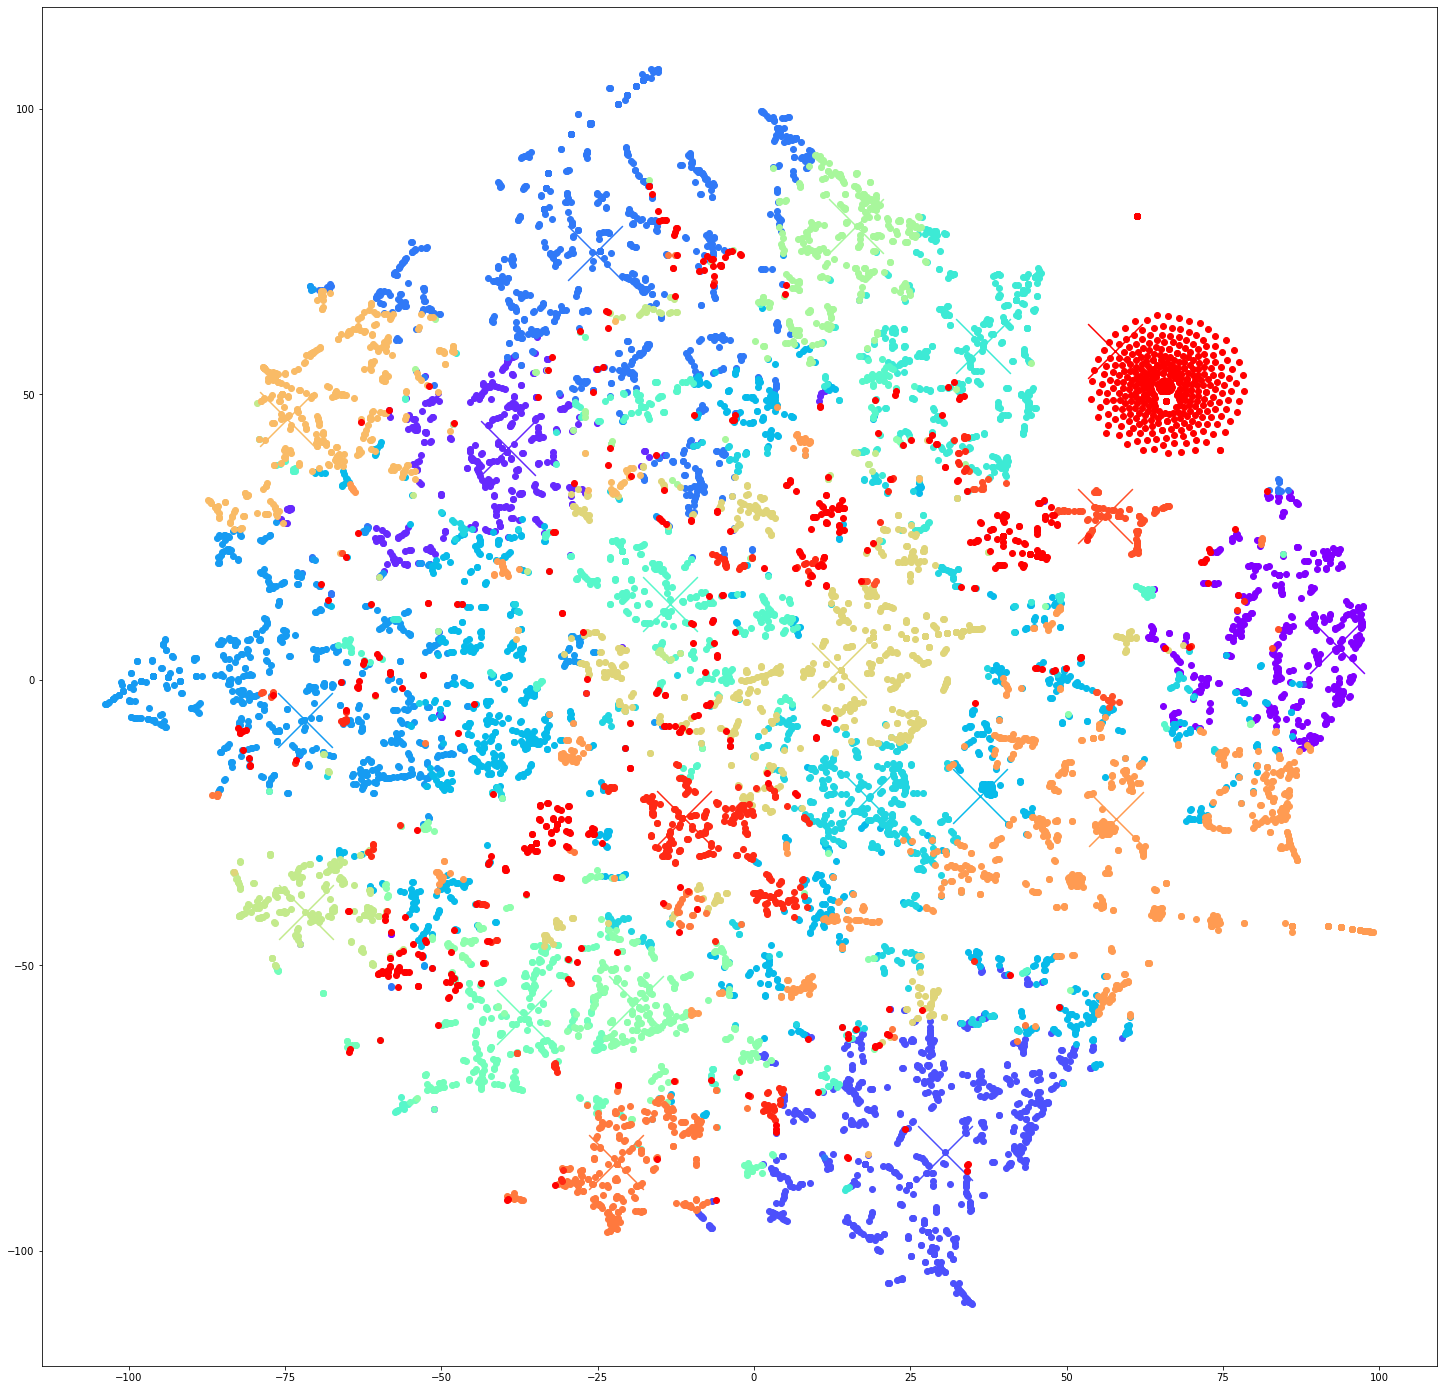

Крестики на ней - это центры тяжести (centroids) кластеров.

На изображении tSNE ембеддингов, видно, что кластеры, выделенные с помощью KMeans, образуют достаточно связные и чаще всего пространственно разделимые между собой множества.

Также можно увидеть, как уменьшилась размерность нашего датасета после применения LDA:

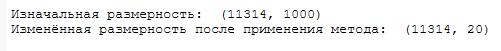